# Image analysis



In [12]:

import numpy as np
import openpyxl
import scipy as sp
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate

import pandas as pd

import matplotlib.pyplot as plt

import os

from PIL import Image

from tifffile import TiffFile

import ipywidgets as widgets
from IPython.display import display, clear_output

import steerable

from skimage.morphology import disk, white_tophat
from skimage.transform import resize
from skimage.measure import profile_line


## Detect nematic order
### Parameter

In [13]:
# Background subtraction
GBlur_Sigma = 2 

# ROIsMask (obtained from Mask)
ROI_Size = 30 # [pixels] 

# Tophat filtering
Tophat_Sigma = 28 

# Steerable Filter
Steerable_Sigma = 2 # Size for Steerable filter  

# Mask treshold to filter interesting structures for ROI 
Mask_Thresh =350 # it varies for different time points of myofibrillogenesis

# ROIsMask (obtained from Mask)
ROI_Thresh = 0.3 # minimal value used, some stages increase up to 0.85

# Padding
Pad_Angle = 6 # Window size --> we will crop image to ensure linescans are not reaching edge of image
Pad_Corr = 3 # [pixel]
ROI_Pad_Corr = (ROI_Size+(ROI_Size*(Pad_Corr-1))*2)

### Image read in

Number of frames: 4
Pixel size: 0.033210633327441764 µm
Image size: 1000 x 1000 pixels


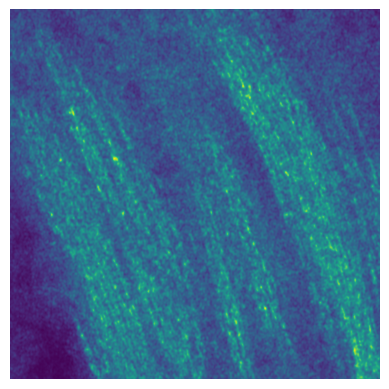

IntSlider(value=0, description='Frame Index', max=3)

In [14]:
# Define the file path
input_figures_directory = 'Data/'
fly1_image_name = '2023.06.12_MhcGFPweeP26_24hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
fly2_image_name = '2023.06.12_MhcGFPweeP26_30hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_2_2.tif'
human_image = 'Trial8_D12_488-TTNrb+633-MHCall_DAPI+568-Rhod_100X_01_stitched.tif'
image_filename = fly1_image_name

raw_path = os.path.join(input_figures_directory, image_filename)

# Open the image
tif = TiffFile(raw_path)

images = np.asarray(tif.asarray())
# Get the number of frames
num_frames = len(images)

# Create slider for frame selection
frame_widget = widgets.IntSlider(min=0, max=num_frames-1, step=1, value=0, description='Frame Index')

# Define the function to display the selected frame
def display_frame(frame_index):
    clear_output(wait=True)
    # Select the frame
    raw = images[frame_index]

    # Get the metadata
    info = tif.pages[frame_index].tags
    
    # Get the image factor
    factor = info['XResolution'].value[0]  # The XResolution tag is a ratio, so we take the numerator
    pixSize = 1 / factor *10**(6)  # Factor to go from pixels to micrometers

    # Get Image size
    nY, nX = raw.shape

    print('Number of frames: ' + str(num_frames))
    print('Pixel size: ' + str(pixSize) + ' µm')
    print('Image size: ' + str(nX) + ' x ' + str(nY) + ' pixels')
    

    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(raw)
    ax.axis('off')  # Remove axis
    plt.show()
    
    # Display the widget
    display(frame_widget)

# Call the function to display the initial frame
display_frame(frame_widget.value)

# Define the function to update the displayed frame
def update_frame(change):
    display_frame(change.new)

# Connect the widget to the update function
frame_widget.observe(update_frame, 'value')

### Select a frame for mask
Fly:
- frame 0: alpha-actinin
- frame 1: actin
- frame 2: myosin
- frame 3: sallimus (MASK CHANNEL)

Human cell:
- frame 0: titin N-terminus (MASK CHANNEL)
- frame 1: muscle myosin
- frame 2: nuclei 
- frame 3: actin


In [15]:
# Get the frame for the mask
frame = 3
raw = images[frame]
info = tif.pages[frame].tags
# Get variables
nY, nX = raw.shape
qLow = np.quantile(raw, 0.001)
qHigh = np.quantile(raw, 0.999)

# get image factor
factor = info['XResolution'].value[0]  # The XResolution tag is a ratio, so we take the numerator
pixSize = 1 / factor *10**(6) # Factor to go from pixels to micrometers


### Mask and background substraction
interactive widget to choose parameters

In [22]:

# Sliders
mask_thresh_slider = widgets.IntSlider(min=0, max=500, step=50, value=Mask_Thresh, description='Mask_Thresh')
roi_thresh_slider = widgets.FloatSlider(min=0, max=0.85, step=0.1, value=ROI_Thresh, description='ROI_Thresh')
roi_size_slider = widgets.IntSlider(min=0, max=50, step=5, value=ROI_Size, description='ROI_Size')
gblur_sigma_slider = widgets.FloatSlider(min=0, max=4, step=0.5, value=GBlur_Sigma, description='GBlur_Sigma')
def display_frame(mask_thresh,roi_thresh, roi_size, gblur_sigma):
    clear_output(wait=True)

    # Crop raw image
    nGridY = int(np.floor(nY / roi_size))
    nGridX = int(np.floor(nX / roi_size))
    raw_crop = raw[:nGridY * roi_size, :nGridX * roi_size]
    nYCrop, nXCrop = raw_crop.shape

    # Subtract background
    raw_bgsub = gaussian_filter(raw_crop, sigma=gblur_sigma)  # Gaussian blur

    # Create Mask
    # Binary mask; I<Threshold --> Black, I>Threshold --> White
    raw_mask = raw_bgsub.copy()
    raw_mask[raw_mask < mask_thresh] = 0
    raw_mask[raw_mask >= mask_thresh] = 1

    # Create ROIsMask
    raw_rois_mask = np.zeros((nGridY, nGridX))
    white_percentage = np.zeros((nGridY, nGridX))
    for i in range(nGridY):
        for j in range(nGridX):
            temp = raw_mask[i*roi_size:(i+1)*roi_size, j*roi_size:(j+1)*roi_size].mean()
            white_percentage[i, j] = temp  # how many pixels per ROI are white
            if temp > roi_thresh:
                if i >= Pad_Angle - 1 and i <= nGridY - Pad_Angle and j >= Pad_Angle - 1 and j <= nGridX - Pad_Angle:
                    raw_rois_mask[i, j] = 1

    # Display
    #plt.figure(figsize=(5, 5))

    # Mask
    plt.subplot(1, 2, 1)
    plt.imshow(raw_mask, cmap='gray')
    plt.title(f'Mask')

    # ROIsMask
    plt.subplot(1, 2, 2)
    plt.imshow(raw_rois_mask, cmap='gray')
    plt.title(f'ROIsMask')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
    

# Display sliders
widgets.interact(display_frame, mask_thresh=mask_thresh_slider, roi_thresh=roi_thresh_slider, roi_size=roi_size_slider, gblur_sigma=gblur_sigma_slider)



interactive(children=(IntSlider(value=350, description='Mask_Thresh', max=500, step=50), FloatSlider(value=0.3…

<function __main__.display_frame(mask_thresh, roi_thresh, roi_size, gblur_sigma)>

#### change parameter if need be

In [17]:
# Background subtraction
GBlur_Sigma = 2 

# ROIsMask (obtained from Mask)
ROI_Size = 30 # [pixels] 

# Tophat filtering
Tophat_Sigma = 28 

# Steerable Filter
Steerable_Sigma = 2 # Size for Steerable filter  

# Mask treshold to filter interesting structures for ROI 
Mask_Thresh =350 # it varies for different time points of myofibrillogenesis

# ROIsMask (obtained from Mask)
ROI_Thresh = 0.3 # minimal value used, some stages increase up to 0.85

# Padding
Pad_Angle = 6 # Window size --> we will crop image to ensure linescans are not reaching edge of image
Pad_Corr = 3 # [pixel]
ROI_Pad_Corr = (ROI_Size+(ROI_Size*(Pad_Corr-1))*2)

#### Mask and ROI Mask with those parameters

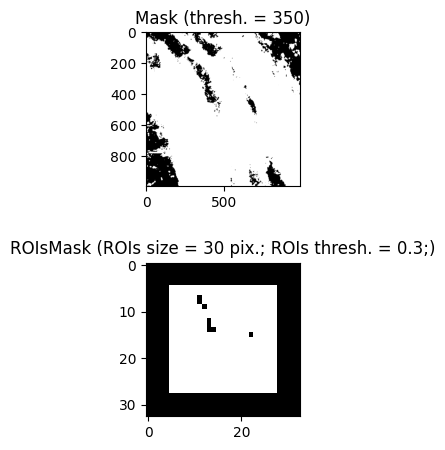

<Figure size 500x500 with 0 Axes>

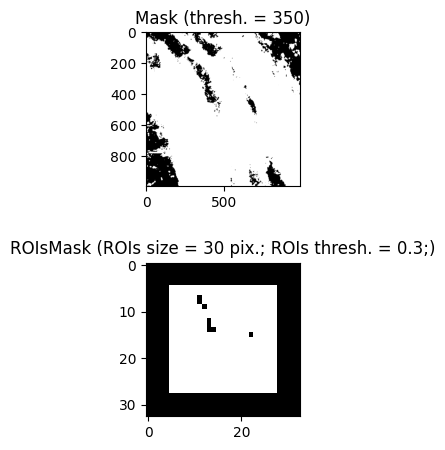

<Figure size 500x500 with 0 Axes>

In [23]:


# Crop raw image
nGridY = int(np.floor(nY / ROI_Size))
nGridX = int(np.floor(nX / ROI_Size))

# TODO: check if this is correct
raw = raw[:nGridY * ROI_Size, :nGridX * ROI_Size]
nYCrop, nXCrop = raw.shape


# Subtract background
Raw_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)  # Gaussian blur #2

# Create Mask
# Binary mask; I<Threshold --> Black, I>Threshold --> White
Raw_Mask = Raw_BGSub.copy()

Raw_Mask[Raw_Mask < Mask_Thresh] = 0
Raw_Mask[Raw_Mask >= Mask_Thresh] = 1

# Create ROIsMask
Raw_ROIsMask = np.zeros((nGridY, nGridX))
white_percentage = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        temp = Raw_Mask[i*ROI_Size:(i+1)*ROI_Size, j*ROI_Size:(j+1)*ROI_Size].mean()
        white_percentage[i, j] = temp  # how many pixels per ROI are white
        if temp > ROI_Thresh:
            if i >= Pad_Angle and i <= nGridY - Pad_Angle and j >= Pad_Angle and j <= nGridX - Pad_Angle:
                Raw_ROIsMask[i, j] = 1

# Crop raw image
nGridY = int(np.floor(nY / ROI_Size))
nGridX = int(np.floor(nX / ROI_Size))

# TODO: check if this is correct
raw = raw[:nGridY * ROI_Size, :nGridX * ROI_Size]
nYCrop, nXCrop = raw.shape


# Subtract background
Raw_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)  # Gaussian blur #2

# Create Mask
# Binary mask; I<Threshold --> Black, I>Threshold --> White
Raw_Mask = Raw_BGSub.copy()

Raw_Mask[Raw_Mask < Mask_Thresh] = 0
Raw_Mask[Raw_Mask >= Mask_Thresh] = 1

# Create ROIsMask
Raw_ROIsMask = np.zeros((nGridY, nGridX))
white_percentage = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        temp = Raw_Mask[i*ROI_Size:(i+1)*ROI_Size, j*ROI_Size:(j+1)*ROI_Size].mean()
        white_percentage[i, j] = temp  # how many pixels per ROI are white
        if temp > ROI_Thresh:
            if i >= Pad_Angle - 1 and i <= nGridY - Pad_Angle and j >= Pad_Angle - 1 and j <= nGridX - Pad_Angle:
                Raw_ROIsMask[i, j] = 1
np.savetxt("comparison/raw.csv", raw, delimiter=",", fmt='%f')
np.savetxt("comparison/Raw_BGSub.csv", Raw_BGSub, delimiter=",", fmt='%f')
np.savetxt("comparison/Raw_Mask.csv", Raw_Mask, delimiter=",", fmt='%f')
np.savetxt("comparison/Raw_ROIsMask.csv", Raw_ROIsMask, delimiter=",", fmt='%f')

# Display

# Mask
plt.subplot(2, 1, 1)
plt.imshow(Raw_Mask, cmap='gray')
plt.title(f'Mask (thresh. = {Mask_Thresh})')

# ROIsMask
plt.subplot(2, 1, 2)
plt.imshow(Raw_ROIsMask, cmap='gray')
plt.title(f'ROIsMask (ROIs size = {ROI_Size} pix.; ROIs thresh. = {ROI_Thresh};)')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
plt.figure(figsize=(5, 5))
plt.show()
# Display

# Mask
plt.subplot(2, 1, 1)
plt.imshow(Raw_Mask, cmap='gray')
plt.title(f'Mask (thresh. = {Mask_Thresh})')

# ROIsMask
plt.subplot(2, 1, 2)
plt.imshow(Raw_ROIsMask, cmap='gray')
plt.title(f'ROIsMask (ROIs size = {ROI_Size} pix.; ROIs thresh. = {ROI_Thresh};)')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
plt.figure(figsize=(5, 5))
plt.show()

interactive widget to choose 'steerable Sigma'

In [24]:
# Create a disk-shaped structuring element
selem = disk(Tophat_Sigma)

# Perform the top-hat transformation
Raw_Tophat = white_tophat(Raw_BGSub, selem)

# slider for steerable filter variable
steerable_sigma_slider = widgets.IntSlider(min=0, max=4, step=0.5, value=Steerable_Sigma, description='Steerable_Sigma')

# Steerable Filter
RawRSize = resize(raw, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation
MaskRSize = resize(Raw_Mask, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation   
# Convert the image to 'double'
RawRSize = RawRSize.astype(np.float64)

def display_frame(steerable_sigma):
    clear_output(wait=True)
    sd = steerable.Detector2D(RawRSize, 2, steerable_sigma)
    res, _ = sd.filter()
    rot = np.transpose(sd.get_angle_response(180))
    for i in range(rot.shape[2]):
        temp = rot[:, :, i]
        temp[MaskRSize == 0] = np.nan
        rot[:, :, i] = temp

    # Make AngleMap
    AngleMap = np.zeros((nGridY, nGridX))
    for i in range(nGridY):
        for j in range(nGridX):
            if Raw_ROIsMask[i, j] == 1:
                Crop = rot[i-(Pad_Angle-1):i+Pad_Angle, j-(Pad_Angle-1):j+Pad_Angle, :]
                idxMax = np.full(Crop.shape[2], np.nan)
                for k in range(Crop.shape[2]):
                    temp = Crop[:, :, k]
                    idxMax[k] = np.nanmean(temp)
                M, I = np.nanmax(idxMax), np.nanargmax(idxMax)
                AngleMap[i, j] = I
    # Display
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(raw, cmap='gray', vmin=qLow, vmax=qHigh)
    plt.title('Raw')

    plt.subplot(3, 1, 2)
    plt.imshow(res, cmap='gray', vmin=np.min(res), vmax=np.max(res))
    plt.title(f'Steerable filter (sigma = {Steerable_Sigma} pix.)')

    Raw_new = np.ones((raw.shape[0], raw.shape[1]))
    plt.subplot(3, 1, 3)
    plt.imshow(Raw_new, cmap='gray', vmin=qLow, vmax=qHigh)
    for i in range(nGridY):
        for j in range(nGridX):
            if Raw_ROIsMask[i, j] == 1:
                Angle = AngleMap[i, j]
                k = 0
                xi = ROI_Size*j + ROI_Size * np.array([-1, 1]) * np.cos((90-Angle)*-1*np.pi/180) + k*np.cos(Angle*np.pi/180)
                yi = ROI_Size*i + ROI_Size * np.array([-1, 1]) * np.sin((90-Angle)*-1*np.pi/180) + k*np.sin(Angle*np.pi/180)
                plt.plot(xi, yi, 'c')
    plt.tight_layout()
    plt.show()

# Display sliders
widgets.interact(display_frame, steerable_sigma=steerable_sigma_slider)
    

interactive(children=(IntSlider(value=2, description='Steerable_Sigma', max=4, step=0), Output()), _dom_classe…

<function __main__.display_frame(steerable_sigma)>

In [ ]:
#change steerable sigma if needed
Steerable_Sigma = 2

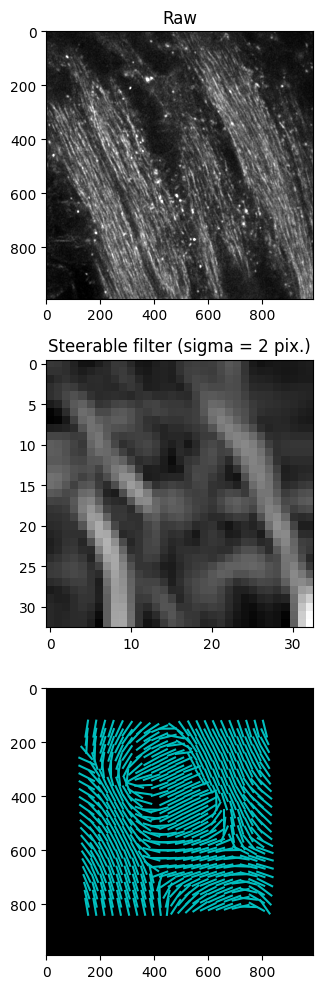

In [37]:
# Top Hat Transformation
#Raw_Tophat = white_tophat(Raw_BGSub, selem=disk(Tophat_Sigma))

# Create a disk-shaped structuring element
selem = disk(Tophat_Sigma)

# Perform the top-hat transformation
Raw_Tophat = white_tophat(Raw_BGSub, selem)

# Measure Local Nematic Order

# Steerable Filter
RawRSize = resize(raw, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation
MaskRSize = resize(Raw_Mask, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation   
# Convert the image to 'double'
RawRSize = RawRSize.astype(np.float64)
# Implement steerableDetector function
sd = steerable.Detector2D(RawRSize, 2, Steerable_Sigma)
res, _ = sd.filter()
np.savetxt("comparison/res.csv", res, delimiter=",", fmt='%f')
rot = np.transpose(sd.get_angle_response(180))
np.savetxt("comparison/rot.csv", rot[:,:,0], delimiter=",", fmt='%f')
for i in range(rot.shape[2]):
    temp = rot[:, :, i]
    temp[MaskRSize == 0] = np.nan
    rot[:, :, i] = temp
np.savetxt("comparison/rot_after.csv", rot[:,:,0], delimiter=",", fmt='%f')

# Make AngleMap
AngleMap = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            Crop = rot[i-(Pad_Angle-1):i+Pad_Angle, j-(Pad_Angle-1):j+Pad_Angle, :]
            idxMax = np.full(Crop.shape[2], np.nan)
            for k in range(Crop.shape[2]):
                temp = Crop[:, :, k]
                idxMax[k] = np.nanmean(temp)
            M, I = np.nanmax(idxMax), np.nanargmax(idxMax)
            AngleMap[i, j] = I
            
# save anglemap as csv
np.savetxt("comparison/AngleMap.csv", AngleMap, delimiter=",", fmt='%f')
# Display
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(raw, cmap='gray', vmin=qLow, vmax=qHigh)
plt.title('Raw')

plt.subplot(3, 1, 2)
plt.imshow(res, cmap='gray', vmin=np.min(res), vmax=np.max(res))
plt.title(f'Steerable filter (sigma = {Steerable_Sigma} pix.)')

Raw_new = np.ones((raw.shape[0], raw.shape[1]))
plt.subplot(3, 1, 3)
plt.imshow(Raw_new, cmap='gray', vmin=qLow, vmax=qHigh)
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            Angle = AngleMap[i, j]
            k = 0
            xi = ROI_Size*j + ROI_Size * np.array([-1, 1]) * np.cos((90-Angle)*-1*np.pi/180) + k*np.cos(Angle*np.pi/180)
            yi = ROI_Size*i + ROI_Size * np.array([-1, 1]) * np.sin((90-Angle)*-1*np.pi/180) + k*np.sin(Angle*np.pi/180)
            plt.plot(xi, yi, 'c')
plt.tight_layout()
plt.show()



# Save all parameters needed for next script
#Parameters = np.array([GBlur_Sigma, Mask_Thresh, ROI_Size, ROI_Thresh, Tophat_Sigma, Steerable_Sigma])
#Parameters = pd.DataFrame(Parameters, index=['GBlur_Sigma', 'Mask_Thresh', 'ROI_Size', 'ROI_Thresh', 'Tophat_Sigma', 'Steerable_Sigma'])

## Correlation function

In [ ]:
import scipy.io

# Define the file path to save the angle map
angle_map_file = 'angle_map.mat'

# Save the AngleMap variable
scipy.io.savemat(angle_map_file, {'AngleMap': AngleMap})


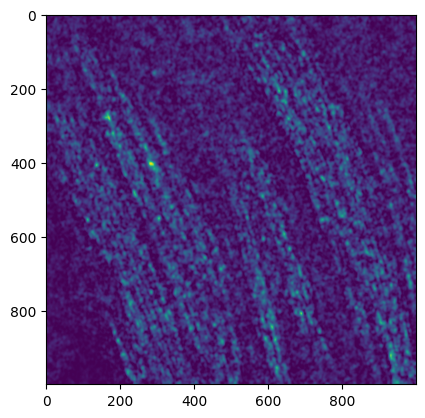

ValueError: operands could not be broadcast together with shapes (281,) (283,) (281,) 

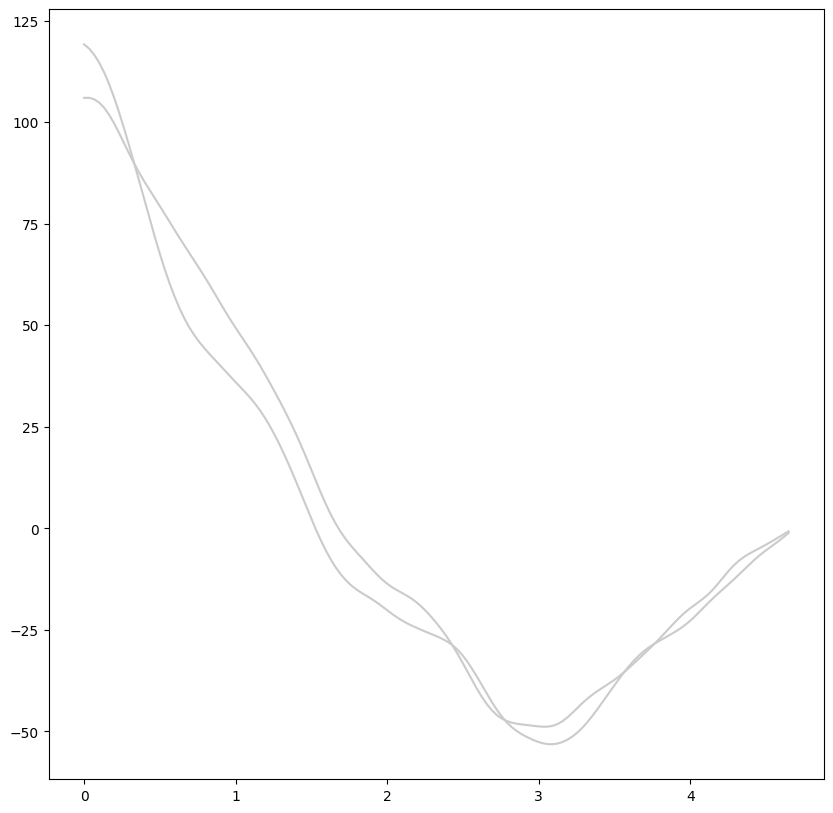

In [ ]:
# Choose the channels
frame1 = 0  # channel for first substrate
frame2 = 3  # channel for second substrate

# get images
raw1 = images[frame1]
raw2 = images[frame2]

# apply masks
raw1_BGSub = gaussian_filter(raw1, sigma=GBlur_Sigma)
selem1 = disk(Tophat_Sigma)
raw1_Tophat = white_tophat(raw1_BGSub, selem1)
# plot raw1_Tophat
plt.imshow(raw1_Tophat)
plt.show()



raw2_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)
selem2 = disk(Tophat_Sigma)
raw2_Tophat = white_tophat(raw2_BGSub, selem2)

# Define constants and parameters
corr_length = 4  # [μm]
crop_length = round(corr_length / (2 * pixSize))  # [pixel]
max_dist = round(crop_length) + 10  # +10 pixels to corr_length to smaller deviations
maxlag = 2 * max_dist  # Correlation length will be doubled because of mirror symmetry

ccf_all = np.full((nGridY * nGridX, 2 * maxlag + 1), np.nan)  # Allocate memory for ACF/CCF
MergedData = np.empty((nGridY, nGridX), dtype=object)
z = 1  # Counting number

fig, ax = plt.subplots(figsize=(10, 10))
# Computation over the whole grid
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            Angle = AngleMap[i, j]
            ccf = np.zeros(2*maxlag+1)
            var1 = 0
            var2 = 0
            kmax = 10

            for k in range(-kmax, kmax+1, 2):
                xi = [ROI_Size*j+max_dist*dir*np.cos((90-Angle)*-1*np.pi/180)+k*np.cos(Angle*np.pi/180) for dir in [-1, 1]]
                yi = [ROI_Size*i+max_dist*dir*np.sin((90-Angle)*-1*np.pi/180)+k*np.sin(Angle*np.pi/180) for dir in [-1, 1]]
                linescan1 = profile_line(raw1_Tophat, (yi[0], xi[0]), (yi[1], xi[1]), linewidth=2*max_dist+1)
                linescan2 = profile_line(raw2_Tophat, (yi[0], xi[0]), (yi[1], xi[1]), linewidth=2*max_dist+1)

                linescan1_mean = np.mean(linescan1)
                linescan1 -= linescan1_mean
                linescan2_mean = np.mean(linescan2)
                linescan2 -= linescan2_mean

                ccf += correlate(linescan1, linescan2, mode='full', method='direct') / (2*kmax+1)
                var1 += np.var(linescan1) / (2*kmax+1)
                var2 += np.var(linescan2) / (2*kmax+1)

            ccf /= np.sqrt(var1 * var2)
            ccf_all[i*nGridX+j, :] = ccf

            maxlag_plot = len(linescan1) - 1
            lags = np.arange(-maxlag, maxlag+1) * pixSize
            ind = np.arange(maxlag_plot, 2*maxlag_plot+1)
            ax.plot(lags[ind], ccf[ind], color='#cccaca')
ax.xlabel('\Delta x [um]')
ax.ylabel('CCF')
ax.title('CCF (unbiased, normalized)')


# Find the valid CCFs/ACFs and calculate the mean
ccf_all_valid = ccf_all[~np.isnan(ccf_all).any(axis=1)]
mean_ccf = np.mean(ccf_all_valid, axis=0)
std_mean_ccf = np.std(ccf_all_valid, axis=0, ddof=1)

ax.plot(lags[ind], mean_ccf[ind], '-', color='#d13111', linewidth=1.8)
ax.plot(lags[ind], mean_ccf[ind] - std_mean_ccf[ind], '--', color='#d13111', linewidth=1.8)
ax.plot(lags[ind], mean_ccf[ind] + std_mean_ccf[ind], '--', color='#d13111', linewidth=1.8)
ax.ylim([-0.5, 1])
ax.xlim([0, corr_length])
ax.tick_params(labelsize=24)
plt.show()



/tmp/ipykernel_34319/2225398848.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread('raw1_Tophat.tif')
/tmp/ipykernel_34319/2225398848.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread('test_mat_Tophat.tif')


Mean Squared Error: 11.516915


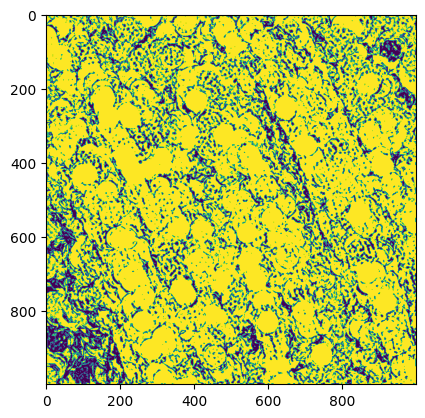

In [ ]:
import imageio

# Load the TIFF files
image1 = imageio.imread('raw1_Tophat.tif')
image2 = imageio.imread('test_mat_Tophat.tif')

# Compare the images
if image1.shape == image2.shape:
    difference = image1 - image2
    plt.imshow(difference)
    mse = (difference ** 2).mean()
    print(f"Mean Squared Error: {mse}")
else:
    print("The images have different shapes and cannot be compared.")
